In [9]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb
from tqdm import tqdm
import scipy.stats


# local libraries
import sys
sys.path.append("..")
import metrics as mt

In [10]:
mt.hello()

you are doing great


In [11]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [12]:
clf_dict = {
    "LR": LogisticRegression,
    "GB": GradientBoostingClassifier,
    "XGB": xgb.XGBClassifier,
}
data_dict = {}

In [15]:
state = "SD"
year = "2014"

for state in ["OH", "DE", "AK", "HI", "SD", "PA", "MI", "GA", "MS"]:
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]["x"] = features
    data_dict[state][year]["y"] = label
    data_dict[state][year]["g"] = group

In [17]:
state = "HI"
for year in ["2014", "2015", "2016", "2017", "2018"]:
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]["x"] = features
    data_dict[state][year]["y"] = label
    data_dict[state][year]["g"] = group

## Section 1: Distribution Shift Across Years

In [30]:
# acoss years
state = "SD"
results = []
for clf in clf_dict:
    for i in range(5):
        year = "2018"
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            data_dict[state][year]["x"],
            data_dict[state][year]["y"],
            data_dict[state][year]["g"],
            test_size=0.2,
            random_state=i,
        )

        if clf == "XBG":
            model = make_pipeline(
                StandardScaler(), clf_dict[clf](objective="binary:logistic")
            )
        else:
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)

        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test)

        results.append(
            {
                "year": year,
                "test_acc": model.score(X_test, y_test),
                "disp": max(g_acc_arr) - min(g_acc_arr),
                "worst_g": min(g_acc_arr),
                "size": len(y_train),
                "run": i,
            }
        )
        for year in ["2018", "2017", "2016", "2015", "2014"]:
            (
                X_train,
                X_test,
                y_train,
                y_test,
                group_train,
                group_test,
            ) = train_test_split(
                data_dict[state][year]["x"],
                data_dict[state][year]["y"],
                data_dict[state][year]["g"],
                test_size=0.4,
                random_state=i,
            )
            yhat = model.predict(X_test)
            corr = yhat == y_test

            g_acc_arr = mt.group_accuracy(corr, group_test)

            results.append(
                {
                    "year": year,
                    "test_acc": model.score(X_test, y_test),
                    "disp": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g": min(g_acc_arr),
                    "size": len(y_train),
                    "run": i,
                    "clf": clf,
                }
            )

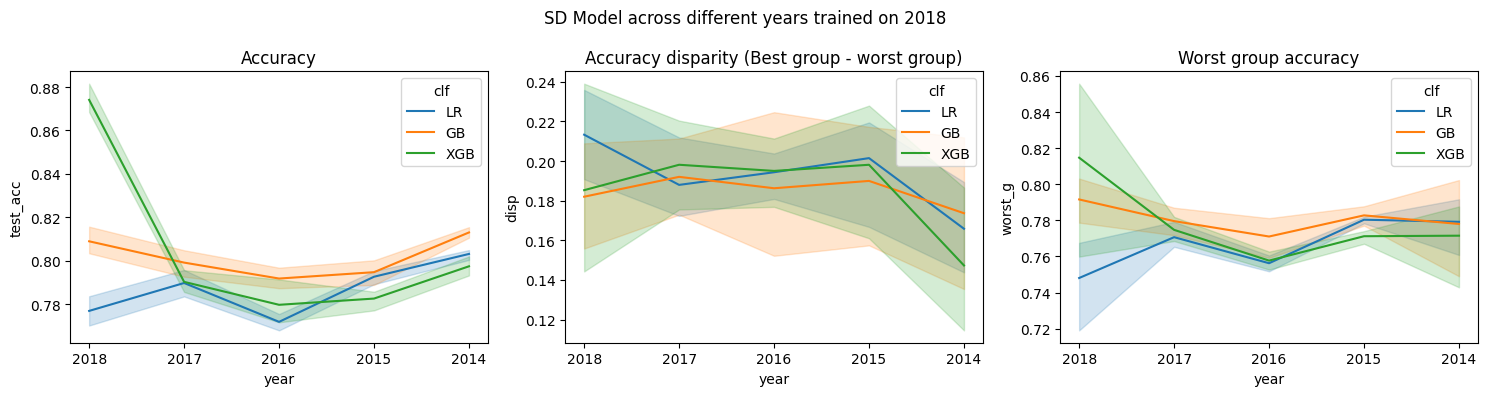

In [33]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x="year", y="test_acc", hue="clf", ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x="year", y="disp", hue="clf", ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x="year", y="worst_g", hue="clf", ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model across different years trained on 2018")
plt.tight_layout()
plt.savefig(f"../results/{state}_shift.pdf")

## Section 2: Distribution Shift across states

In [298]:
# acoss states
results = [] 
year='2014'
for clf in clf_dict: 
    for i in range(5): 
        ref_state = 'CA'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[ref_state][year]['x'],
                    data_dict[ref_state][year]['y'], 
                    data_dict[ref_state][year]['g'], test_size=0.2, random_state=i)

        if clf == 'XBG': 
            model = make_pipeline(StandardScaler(), 
                                  clf_dict[clf](objective="binary:logistic"))
        else: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test) 

        results.append({
            'year': year, 
            'state': ref_state, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
            'clf': clf,
        })
        for state in data_dict.keys(): 
            if state != ref_state: 
                X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                        data_dict[state][year]['x'],
                        data_dict[state][year]['y'], 
                        data_dict[state][year]['g'], test_size=0.4, random_state=i)
                yhat = model.predict(X_test)
                corr = yhat == y_test
                g_acc_arr = mt.group_accuracy(corr, group_test) 

                results.append({
                'year': year, 
                'state': state, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr), 
                'worst_g': min(g_acc_arr), 
                'size': len(y_train), 
                'run': i, 
                'clf': clf,
            })

Text(0.5, 0.98, '2014 CA model on other states')

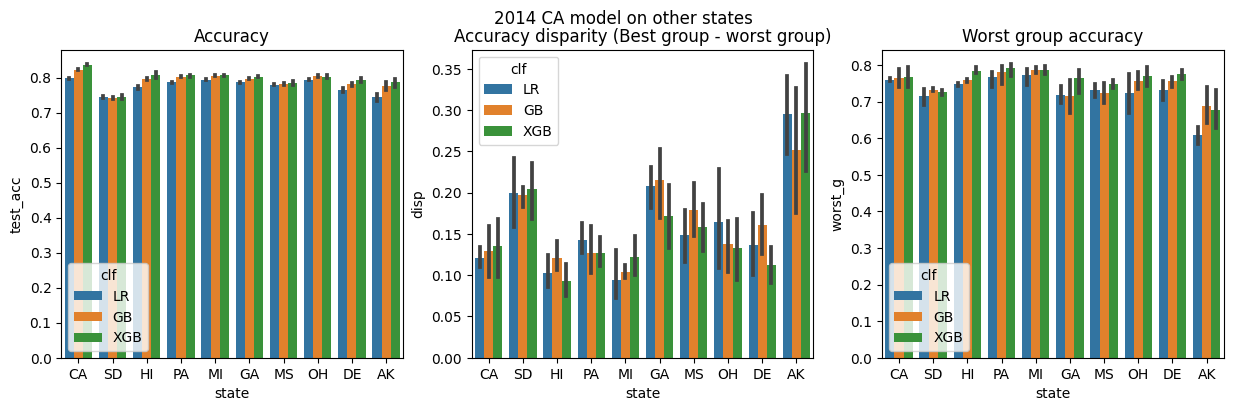

In [299]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=results_df, x='state', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.barplot(data=results_df, x='state', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.barplot(data=results_df, x='state', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"2014 {ref_state} model on other states")

## Section 3: South Dakota case study

### Step 1: With in the SD dataset, more data is better

In [79]:
results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000]
for clf in clf_dict.keys(): 
    for size in size_arr: 
        print(size)
        for run in range(5): 
            

            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                data_dict[state][year]['x'], 
                data_dict[state][year]['y'], 
                data_dict[state][year]['g'], test_size=0.2, random_state=0)
            
            incl = np.asarray(random.sample(range(len(y_train)), size))
            
            X_train = X_train[incl]
            y_train = y_train[incl]
            if clf == 'XBG': 
                model = make_pipeline(StandardScaler(), 
                                      clf_dict[clf](objective="binary:logistic"))
            else: 
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_train, y_train)
            
            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

50
100
500
1000
2000
50
100
500
1000
2000
50
100
500
1000
2000


Text(0.5, 0.98, 'SD Model with increasing datasize')

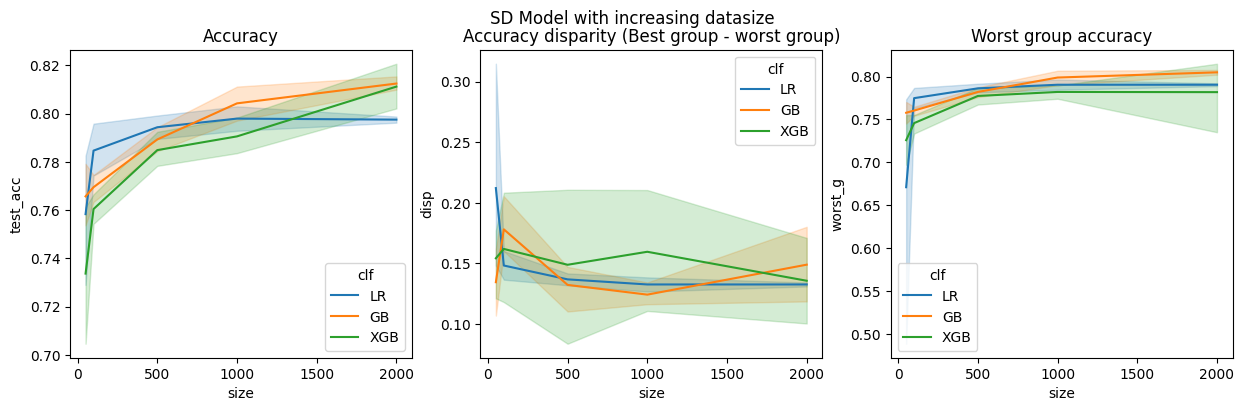

In [80]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model with increasing datasize")

### Part 2: Example the effect of adding more data in the sequential and mixture setting

In [509]:
len(data_dict["CA"]["2014"]["x"]), len(data_dict["SD"]["2014"]["x"])

(183941, 4747)

In [500]:
# sequential

results = []
state = "SD"
year = "2014"
mixture = True
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000, 12000, 14000, 16000]
for run in range(5):
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]["x"],
        data_dict[state][year]["y"],
        data_dict[state][year]["g"],
        test_size=0.2,
        random_state=run,
    )

    X_joint = np.concatenate((X_train, data_dict["CA"][year]["x"]))
    y_joint = np.concatenate((y_train, data_dict["CA"][year]["y"]))
    g_joint = np.concatenate((group_train, data_dict["CA"][year]["g"]))

    if mixture:
        p = np.random.permutation(len(X_joint[:size]))
        X_joint = X_joint[p]
        y_joint = y_joint[p]
        g_joint = g_joint[p]
        
    for clf in clf_dict.keys():
        for size in size_arr:
            if clf == "XBG":
                model = make_pipeline(
                    StandardScaler(), clf_dict[clf](objective="binary:logistic")
                )
            else:
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append(
                {
                    "train_acc": train_acc,
                    "test_acc": test_acc,
                    "disp": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g": min(g_acc_arr),
                    "size": size,
                    "run": run,
                    "clf": clf,
                }
            )

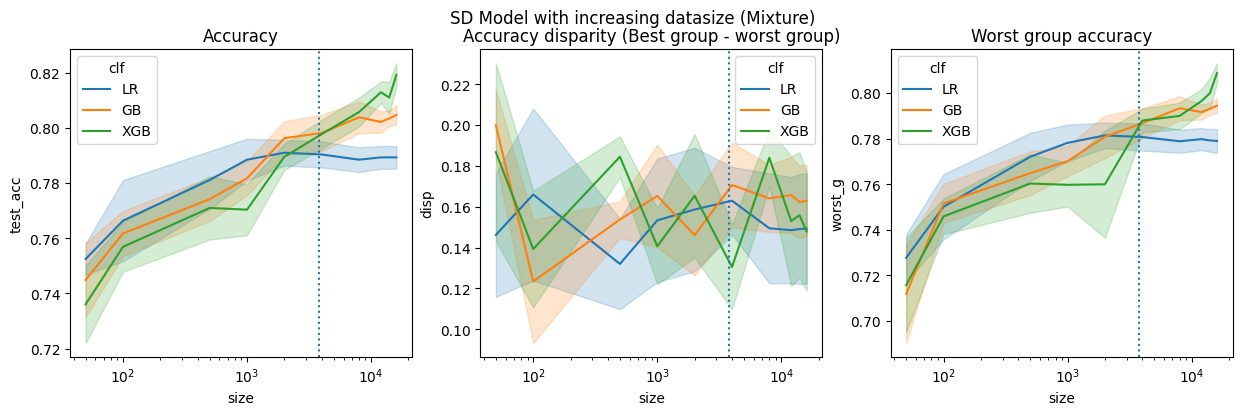

In [441]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(
    data=results_df, x="size", y="test_acc", hue="clf", errorbar="se", ax=axes[0]
)
axes[0].axvline(x=len(X_train), linestyle=":")
axes[0].set_xscale("log")
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x="size", y="disp", hue="clf", errorbar="se", ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=":")
axes[1].set_xscale("log")

sns.lineplot(
    data=results_df, x="size", y="worst_g", hue="clf", errorbar="se", ax=axes[2]
)
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=":")
axes[2].set_xscale("log")
if mixture:
    plt.suptitle(f"{state} Model with increasing datasize (Mixture)")
else:
    plt.suptitle(f"{state} Model with increasing datasize (Sequential)")

### Part 3: Check the effect of adding more data from SD in different years

In [34]:
results = []
state = "SD"
year = "2018"
train_year = "2016"
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000]
for run in range(5):
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]["x"],
        data_dict[state][year]["y"],
        data_dict[state][year]["g"],
        test_size=0.2,
        random_state=run,
    )

    X_joint = np.concatenate((X_train, data_dict[state][train_year]["x"]))
    y_joint = np.concatenate((y_train, data_dict[state][train_year]["y"]))
    g_joint = np.concatenate((group_train, data_dict[state][train_year]["g"]))

    for clf in clf_dict.keys():
        for size in size_arr:
            if clf == "XBG":
                model = make_pipeline(
                    StandardScaler(), clf_dict[clf](objective="binary:logistic")
                )
            else:
                model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append(
                {
                    "train_acc": train_acc,
                    "test_acc": test_acc,
                    "disp": max(g_acc_arr) - min(g_acc_arr),
                    "worst_g": min(g_acc_arr),
                    "size": size,
                    "run": run,
                    "clf": clf,
                }
            )

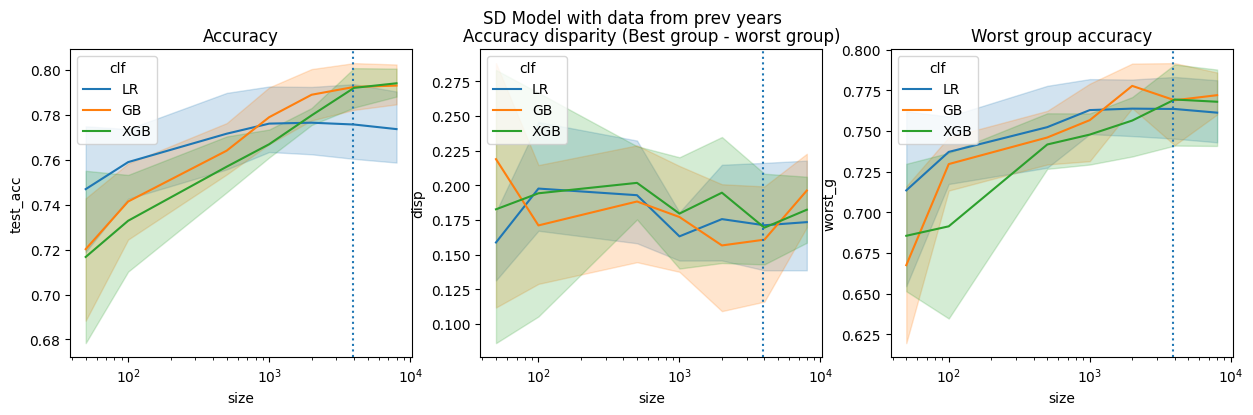

In [35]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x="size", y="test_acc", hue="clf", ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=":")
axes[0].set_xscale("log")
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x="size", y="disp", hue="clf", ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=":")
axes[1].set_xscale("log")

sns.lineplot(data=results_df, x="size", y="worst_g", hue="clf", ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=":")
axes[2].set_xscale("log")
plt.suptitle(f"{state} Model with data from prev years")
plt.savefig(f"../results/temporal_sequential_{state}.pdf")

## Section 3: Empirical KL

### Part 1: Evaluate KL via empirical kernel density estimation between source and target distributiosn (States)

In [306]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import scipy.special as sp
from sklearn.model_selection import GridSearchCV

In [307]:
# run state classifier in above
state_results = results_df
states_mean = state_results.groupby(['state', 'clf']).mean()

In [452]:
ref_state = "CA"
samples = 3000
joint_xy_ref = np.concatenate(
    (data_dict[ref_state][year]["x"], data_dict[ref_state][year]["y"].reshape(-1, 1)),
    axis=1,
)

incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples))

cx, pkdex = mt.init_density_scale(data_dict[ref_state][year]["x"][incl])

cxy, pkdexy = mt.init_density_scale(joint_xy_ref[incl])

num_iter = 1
for i in range(num_iter):
    kl_df = pd.DataFrame()
    for state in data_dict.keys():
        print(state)
        if state != ref_state:
            joint_xy = np.concatenate(
                (
                    data_dict[state][year]["x"],
                    data_dict[state][year]["y"].reshape(-1, 1),
                ),
                axis=1,
            )

            diff_df = states_mean.loc[ref_state] - states_mean.loc[state]

            # sample
            incl = np.asarray(random.sample(range(len(joint_xy)), samples))
            qkdexy = mt.init_density(joint_xy[incl], cxy)
            qkdex = mt.init_density(data_dict[state][year]["x"][incl], cx)

            diff_df["KL_x"] = mt.entropy_input(
                data_dict[ref_state][year]["x"][incl], pkdex, qkdex, cx
            )
            diff_df["KL_xy"] = mt.entropy_input(joint_xy_ref[incl], pkdexy, qkdexy, cxy)
            diff_df["state"] = state
            diff_df["iter"] = i
            kl_df = pd.concat((kl_df, diff_df))
kl_df.to_csv("results/kl_shift.csv")

best bandwidth: 0.37926901907322497
best bandwidth: 0.37926901907322497
SD
CA
HI
PA
MI
GA
MS
OH
DE
AK


In [496]:
kl_df.shape

(27, 11)

0.6367026343874624 0.0003559735826722909


Text(0.5, 0.98, 'KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop')

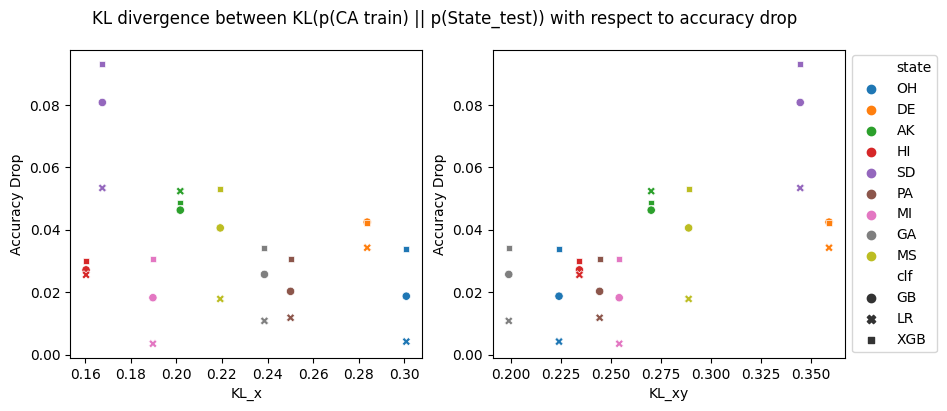

In [463]:
kl_df = pd.read_csv("results/kl_shift.csv")
kl_df = kl_df.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(
    data=kl_df,
    x="KL_x",
    y="test_acc",
    hue="state",
    style="clf",
    ax=axes[0],
    legend=False,
)
axes[0].set_ylabel("Accuracy Drop")
coeff, p = scipy.stats.pearsonr(kl_df["test_acc"], kl_df["KL_xy"])
print(coeff, p)
sns.scatterplot(
    data=kl_df,
    x="KL_xy",
    y="test_acc",
    style="clf",
    hue="state",
    ax=axes[1],
)
axes[1].set_ylabel("Accuracy Drop")
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle(
    "KL divergence between KL(p(CA train) || p(State_test)) with respect to accuracy drop"
)

### Part 2: Evaluate Excess KL across states

In [428]:
# calculate KL to current data vs kl to new dataset
# scatter plot x=excess kl y = accuracy improvement, these points should come from many states:

# sequential
results = []
state = "SD"
year = "2014"

# init kde and transform with SD data
joint_xy_ref = np.concatenate(
    (data_dict[ref_state][year]["x"], data_dict[ref_state][year]["y"].reshape(-1, 1)),
    axis=1,
)
incl = np.asarray(random.sample(range(len(joint_xy_ref)), samples * 2))

cx, qkdex = mt.init_density_scale(data_dict[ref_state][year]["x"][incl])
cxy, qkdexy = mt.init_density_scale(joint_xy_ref[incl])

mixture = False
size_arr = [3500, 7500]
for extra_state in tqdm(data_dict.keys()):
    if extra_state != state:
        for run in range(1):
            (
                X_train,
                X_test,
                y_train,
                y_test,
                group_train,
                group_test,
            ) = train_test_split(
                data_dict[state][year]["x"],
                data_dict[state][year]["y"],
                data_dict[state][year]["g"],
                test_size=0.25,
                random_state=run,
            )

            X_joint = np.concatenate((X_train, data_dict[extra_state][year]["x"]))
            y_joint = np.concatenate((y_train, data_dict[extra_state][year]["y"]))
            g_joint = np.concatenate((group_train, data_dict[extra_state][year]["g"]))

            Xy_joint = np.concatenate((X_joint, y_joint.reshape(-1, 1)), axis=1)

            for size in size_arr:
                # sample
                pkdex = mt.init_density(X_joint[:size], cx)
                pkdexy = mt.init_density(Xy_joint[:size], cxy)
                kl_x = mt.entropy_input(X_joint[:size], pkdex, qkdex, cx)
                kl_xy = mt.entropy_input(Xy_joint[:size], pkdexy, qkdexy, cxy)

                for clf in clf_dict.keys():
                    if clf == "XBG":
                        model = make_pipeline(
                            StandardScaler(), clf_dict[clf](objective="binary:logistic")
                        )
                    else:
                        model = make_pipeline(StandardScaler(), clf_dict[clf]())

                        model.fit(X_joint[:size], y_joint[:size])

                        yhat = model.predict(X_test)
                        corr = yhat == y_test
                        g_acc_arr = mt.group_accuracy(corr, group_test)

                        train_acc = model.score(X_train, y_train)

                        test_acc = model.score(X_test, y_test)

                        results.append(
                            {
                                "train_acc": train_acc,
                                "test_acc": test_acc,
                                "disp": max(g_acc_arr) - min(g_acc_arr),
                                "worst_g": min(g_acc_arr),
                                "kl_testx": kl_x,
                                "kl_testxy": kl_xy,
                                "size": size,
                                "run": run,
                                "clf": clf,
                                "extra_state": extra_state,
                            }
                        )

best bandwidth: 0.37926901907322497
best bandwidth: 0.37926901907322497


100%|████████████████████████████████████████████████████████████████████████| 10/10 [19:28<00:00, 116.85s/it]


In [429]:
results_df = pd.DataFrame(results)

In [430]:
q1_results = results_df[results_df["size"] == 3500].reset_index()[
    ["test_acc", "clf", "extra_state", "kl_testx", "kl_testxy"]
]

In [431]:
q2_results = results_df[results_df["size"] == 7500].reset_index()[
    ["test_acc", "clf", "extra_state", "kl_testx", "kl_testxy"]
]

In [432]:
diff_results = pd.DataFrame()
diff_results["acc_diff"] = q1_results["test_acc"] - q2_results["test_acc"]
diff_results["klx_diff"] = q1_results["kl_testx"] - q2_results["kl_testx"]
diff_results["klxy_diff"] = q1_results["kl_testxy"] - q2_results["kl_testxy"]
diff_results["clf"] = q1_results["clf"]
diff_results["extra_state"] = q1_results["extra_state"]

In [447]:
diff_results.to_csv("results/excess_kl.csv")

In [497]:
len(clf_df["acc_diff"])

9

0.7140043436408565 0.030721684366751743


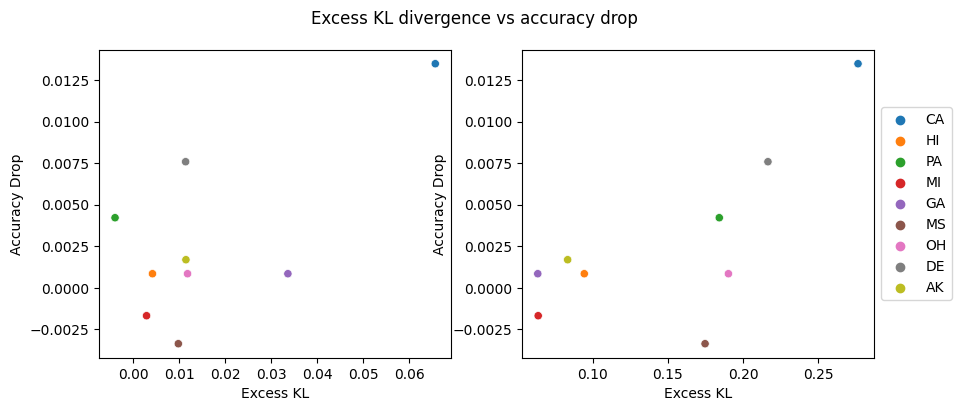

0.5710750706656593 0.10825390320096044


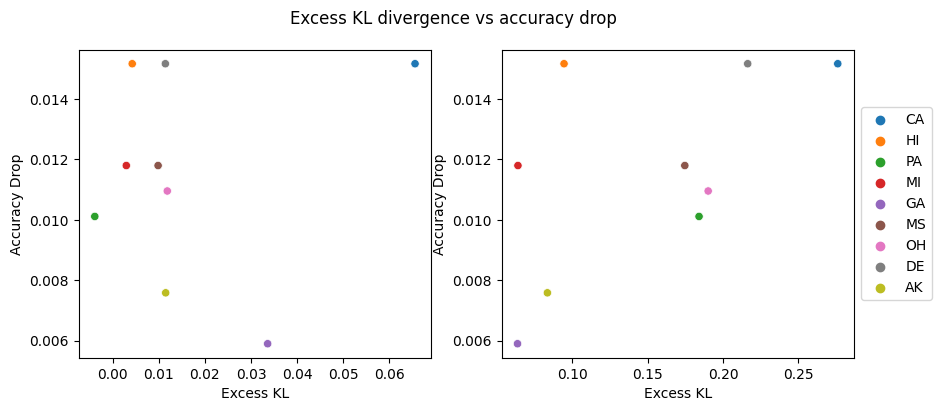

-0.0276523176181723 0.9437030445633947


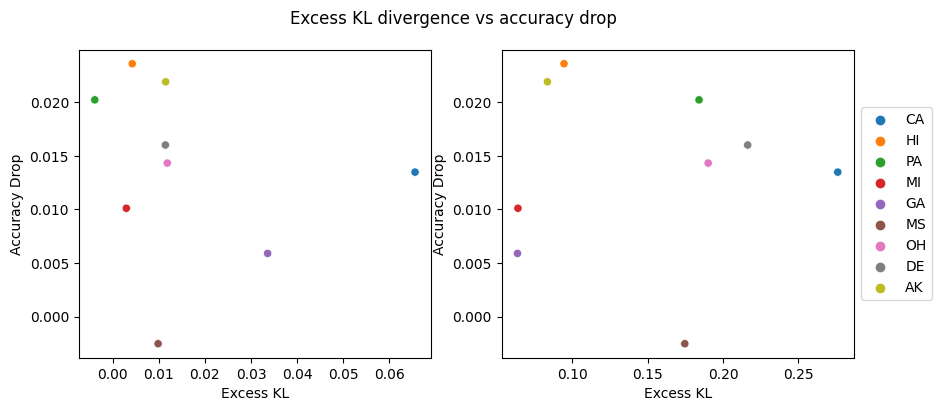

In [469]:
for clf in clf_dict.keys():
    clf_df = diff_results[diff_results["clf"] == clf]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.scatterplot(
        data=clf_df,
        x="klx_diff",
        y="acc_diff",
        hue="extra_state",
        # style="clf",
        ax=axes[0],
        legend=False,
    )
    axes[0].set_xlabel("Excess KL")
    axes[0].set_ylabel("Accuracy Drop")
    sns.scatterplot(
        data=clf_df,
        x="klxy_diff",
        y="acc_diff",
        hue="extra_state",
        # style="clf",
        ax=axes[1],
    )
    axes[1].set_xlabel("Excess KL")
    axes[1].set_ylabel("Accuracy Drop")
    axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    coeff, p = scipy.stats.pearsonr(clf_df["acc_diff"], clf_df["klxy_diff"])
    print(coeff, p)
    plt.suptitle("Excess KL divergence vs accuracy drop")
    plt.show()

In [491]:
kl_df = pd.read_csv("results/kl_shift.csv")
diff_results = pd.read_csv("results/excess_kl.csv")

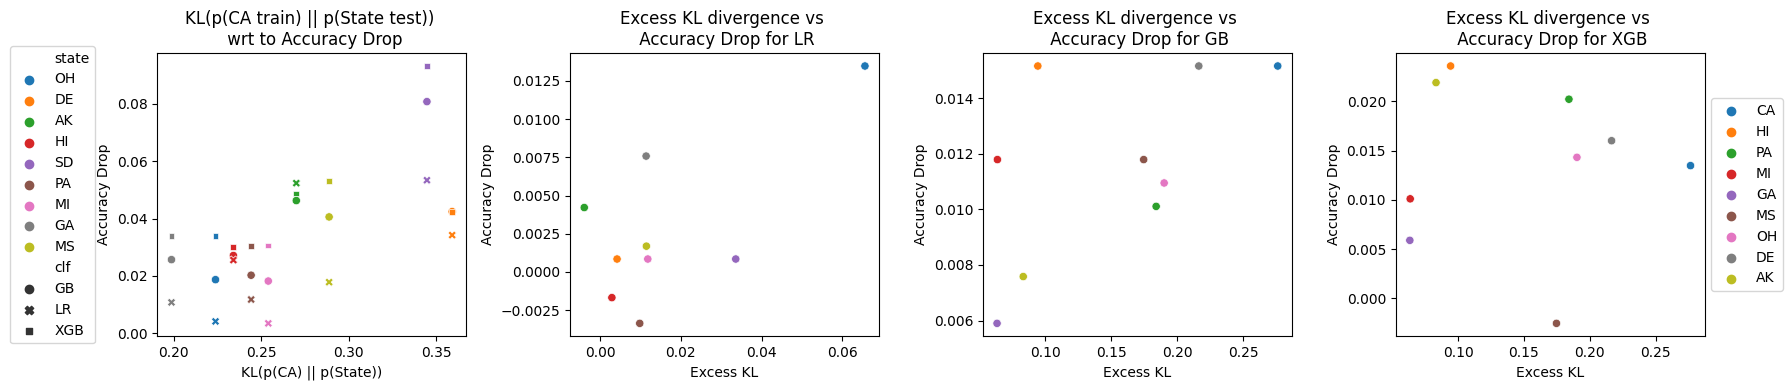

In [494]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
sns.scatterplot(
    data=kl_df,
    x="KL_xy",
    y="test_acc",
    style="clf",
    hue="state",
    ax=axes[0],
)
axes[0].set_ylabel("Accuracy Drop")
axes[0].set_xlabel("KL(p(CA) || p(State))")
axes[0].legend(loc="center left", bbox_to_anchor=(-0.5, 0.5))
axes[0].set_title("KL(p(CA train) || p(State test)) \n wrt to Accuracy Drop")

sns.scatterplot(
    data=diff_results[diff_results["clf"] == "LR"],
    x="klx_diff",
    y="acc_diff",
    hue="extra_state",
    # style="clf",
    ax=axes[1],
    legend=False,
)
axes[1].set_xlabel("Excess KL")
axes[1].set_ylabel("Accuracy Drop")
axes[1].set_title("Excess KL divergence vs \n Accuracy Drop for LR")

sns.scatterplot(
    data=diff_results[diff_results["clf"] == "GB"],
    x="klxy_diff",
    y="acc_diff",
    hue="extra_state",
    legend=False,
    # style="clf",
    ax=axes[2],
)
axes[2].set_xlabel("Excess KL")
axes[2].set_ylabel("Accuracy Drop")
# axes[2].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[2].set_title("Excess KL divergence vs \n Accuracy Drop for GB")


sns.scatterplot(
    data=diff_results[diff_results["clf"] == "XGB"],
    x="klxy_diff",
    y="acc_diff",
    hue="extra_state",
    legend=True,
    # style="clf",
    ax=axes[3],
)
axes[3].set_xlabel("Excess KL")
axes[3].set_ylabel("Accuracy Drop")
axes[3].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[3].set_title("Excess KL divergence vs \n Accuracy Drop for XGB")
fig.tight_layout()
plt.savefig("KL.pdf")
plt.show()